In [1]:
#input files
import os 
import geopandas as gpd
from shapely.geometry import Point
folder = '/Users/Zack/0_thesis_bing/images/'

In [2]:
#https://www.timpoulsen.com/2018/finding-the-dominant-colors-of-an-image.html
# import cv2
# import numpy as np

# #function to generate mean color of an image
# def mean_rgb(folder, file):
#     img = cv2.imread(folder + file)
#     height, width, _ = np.shape(img)
#     avg_color_per_row = np.average(img, axis=0)
#     avg_colors = np.average(avg_color_per_row, axis=0)
#     int_averages = np.array(avg_colors, dtype=np.uint8)
#     return int_averages.tolist()

# mean_rgb(folder, file)

In [3]:
#sort images by size (reverse=False: smallest to largest)
def get_files_by_file_size(dirname, reverse=False):  
    
    # Get list of files
    filepaths = []
    for basename in os.listdir(dirname):
        filename = os.path.join(dirname, basename)
        if os.path.isfile(filename):
            filepaths.append(filename)

    # Re-populate list with filename, size tuples
    for i in range(len(filepaths)):
        filepaths[i] = (filepaths[i], os.path.getsize(filepaths[i]))
        
    filepaths.sort(key=lambda filename: filename[1], reverse=reverse)
    
    # Re-populate list with just filenames
    for i in range(len(filepaths)):
        filepaths[i] = filepaths[i][0]
    
    return filepaths

In [40]:
#https://www.dataquest.io/blog/tutorial-colors-image-clustering-python/
import scipy
import pandas as pd 
from matplotlib import image as img
from scipy.cluster.vq import whiten, kmeans

#convert rgb to hex
def rgb_to_hex(rgb):
    rgb = (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return '%02x%02x%02x' % rgb  

#identify dominant color in an image
def dom_rgb(file):
    image = img.imread(file)
#     #plot image
#     print(image.shape)
#     plt.imshow(image)
#     plt.show()

    #generate data frame
    r, g, b = [], [], []
    for line in image:
        for pixel in line:
            temp_r, temp_g, temp_b = pixel
            r.append(temp_r)
            g.append(temp_g)
            b.append(temp_b)
            
    #plot
#     from mpl_toolkits.mplot3d import Axes3D
#     fig = plt.figure()
#     ax = Axes3D(fig)
#     ax.scatter(r, g, b)
#     plt.show()

    df = pd.DataFrame({'red': r,'blue': b,'green': g})
    df['scaled_red'] = whiten(df['red'])
    df['scaled_blue'] = whiten(df['blue'])
    df['scaled_green'] = whiten(df['green'])

    cluster_center, distortion = kmeans(df[['scaled_red', 'scaled_green', 'scaled_blue']], 1)

    std = df[['red', 'green', 'blue']].std()
    r=cluster_center[0][0] * std[0]
    g=cluster_center[0][1] * std[1]
    b=cluster_center[0][2] * std[2]
    rgb = [round(r), round(g), round(b)]
    return rgb

In [46]:
files = get_files_by_file_size(folder, reverse=False)
f = files[20:len(files)]
f = files[20:200]
print(len(files))
print(len(f))

#generate dominant color for all images in folder
rgb_values, hex_values = [], []
for i in (f):
    rgb = dom_rgb(i)
    hex_color = rgb_to_hex(rgb)
    rgb_values.append(rgb)
    hex_values.append(hex_color)   

#add centroid data drame
x_list, y_list = [], []
for i in (f):
    xy = i.split(", ")
    x = float(xy[2])
    y = float(xy[1])
    x_list.append(x)
    y_list.append(y)

#create datafram and sort by hex value
color_list = pd.DataFrame({'image': f,
                           'rgb' : rgb_values, 
                           'hex' : hex_values}).sort_values(by='hex')

color_list = gpd.GeoDataFrame(color_list, 
                              crs = {'init' :'epsg:4326'},
                              geometry = [Point(xy) for xy in zip(x_list, y_list)])
print(color_list.shape)
color_list.head()

3816
180
(180, 4)


,image,rgb,hex,geometry
42,"/Users/Zack/0_thesis_bing/images/image_(19, 37...","[3.0, 29.0, 20.0]",031d14,POINT (23.42744 37.74417)
1,"/Users/Zack/0_thesis_bing/images/image_(19, 37...","[4.0, 23.0, 21.0]",041715,POINT (23.68244 37.93093)
65,"/Users/Zack/0_thesis_bing/images/image_(19, 37...","[5.0, 17.0, 15.0]",05110f,POINT (23.51311 38.00514)
2,"/Users/Zack/0_thesis_bing/images/image_(19, 38...","[8.0, 6.0, 17.0]",080611,POINT (23.49802 38.01016)
137,"/Users/Zack/0_thesis_bing/images/image_(19, 37...","[8.0, 17.0, 16.0]",081110,POINT (23.51372 38.01056)


162.0


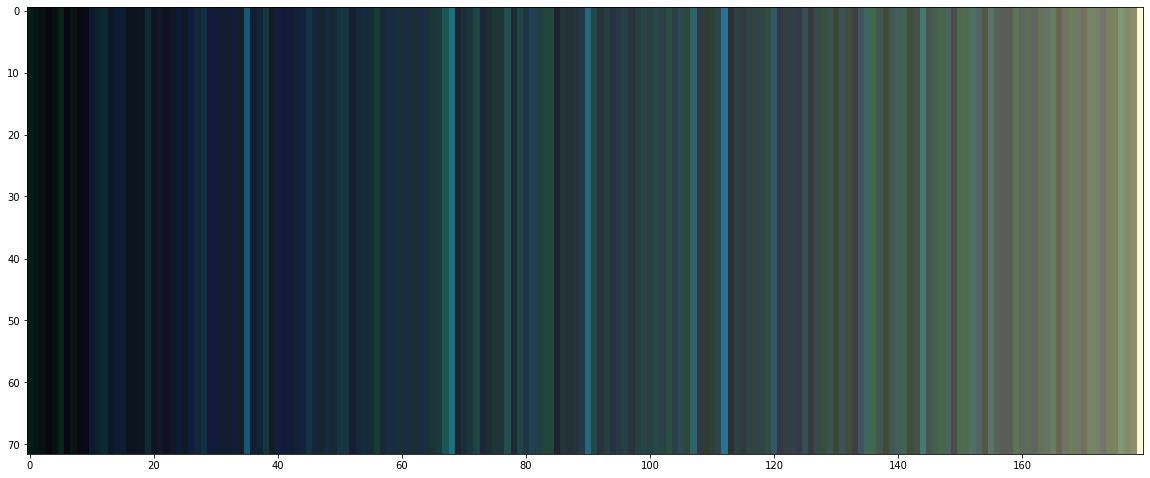

In [47]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

barColors = color_list['rgb'].tolist()
barColors = (np.array(barColors)).astype(np.uint8)

#creating bar image
cols = len(barColors)
rows = max([1,int(cols/2.5)])

# Create color Array
barFullData = np.tile(barColors, (rows,1)).reshape(rows, cols, 3)

# Create Image from Array
barImg = Image.fromarray(barFullData, 'RGB')

plt.figure(figsize=(20,10))
plt.imshow(barImg)

#exclusion limit
print(cols - (cols * .1))

In [17]:
#select exclusions
exclude = color_list[3416:]
print(len(exclude))
exclude = exclude.to_crs({'init': 'epsg:2100'})

#buffer centroids and make square polygons
exclude_buffer = gpd.GeoDataFrame(geometry = exclude.buffer(5))
# exclude_buffer.plot(edgecolor = 'black', facecolor = 'none')

380


In [10]:
# f = '/Users/Zack/0_GIS_Greece/'
# search_area = gpd.read_file(f + '/AOI/' + 'mask_search_area_100m_5km.shp')
# search_area = search_area.to_crs({'init': 'epsg:2100'})

# plt.rcParams['figure.figsize'] = (20, 10)
# ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
# exclude_buffer.plot(linewidth=1, edgecolor = 'red', facecolor = 'red', ax=ax)

In [21]:
exclude_export = exclude_buffer.copy()
exclude_export

,geometry
2338,"POLYGON ((394515.2497516793 4488668.066398829,..."
2196,"POLYGON ((396661.5621279264 4489959.298467763,..."
3311,"POLYGON ((406704.9156226916 4496485.168650612,..."
3321,"POLYGON ((534162.165550824 4530851.508056336, ..."
2579,"POLYGON ((708062.2218760912 3908642.669380098,..."
...,...
2487,"POLYGON ((469022.6450899274 4198612.923050617,..."
1718,"POLYGON ((609489.845365189 4421769.238628997, ..."
1177,"POLYGON ((477495.1605726118 4190130.87975865, ..."
1228,"POLYGON ((464452.0678191894 4208298.917099605,..."


In [22]:
# exclude_export = exclude_buffer.copy()
# exclude_export = exclude_export['geometry'].to_crs(epsg=4326)
# exclude_export.to_file('/Users/Zack/Desktop/buffer.shp')
# # exclude_export.to_file('/Users/Zack/Desktop/buffer.geojson', driver='GeoJSON')

# exclude_pt = exclude.copy()
# exclude_pt = exclude_pt['geometry'].to_crs(epsg=4326)
# exclude_pt.to_file('/Users/Zack/Desktop/exclude_pt.shp')

# color_list.to_csv ('/Users/Zack/Desktop/color_list.csv', index = None, header=True)